In [1]:
from pyspark.sql import SparkSession

In [2]:
from pyspark.sql.functions import rand, randn

In [3]:
spark = SparkSession.builder.appName('k_means').getOrCreate()  #创建SparkSession对象

In [4]:
df=spark.read.csv('iris_dataset.csv',inferSchema=True,header=True) 

In [5]:
print((df.count(),len(df.columns)))  

(150, 5)


In [6]:
df.orderBy(rand()).show(10,False)    #查看数据，随机的方式

+------------+-----------+------------+-----------+----------+
|sepal_length|sepal_width|petal_length|petal_width|species   |
+------------+-----------+------------+-----------+----------+
|5.7         |2.8        |4.5         |1.3        |versicolor|
|6.1         |2.9        |4.7         |1.4        |versicolor|
|5.5         |2.3        |4.0         |1.3        |versicolor|
|5.4         |3.0        |4.5         |1.5        |versicolor|
|4.9         |3.0        |1.4         |0.2        |setosa    |
|6.4         |2.9        |4.3         |1.3        |versicolor|
|5.8         |2.8        |5.1         |2.4        |virginica |
|5.2         |3.5        |1.5         |0.2        |setosa    |
|4.4         |2.9        |1.4         |0.2        |setosa    |
|6.7         |3.0        |5.0         |1.7        |versicolor|
+------------+-----------+------------+-----------+----------+
only showing top 10 rows



In [7]:
df.groupBy('species').count().orderBy('count',ascending=False).show(10,False) # 汇总查看数据

+----------+-----+
|species   |count|
+----------+-----+
|virginica |50   |
|versicolor|50   |
|setosa    |50   |
+----------+-----+



In [50]:
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [13]:
#特征装换功能，将鸢尾花的四个特征数据值，装换为一个特征向量
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [14]:
input_cols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [15]:
vec_as = VectorAssembler(inputCols = input_cols, outputCol='features')
data = vec_as.transform(df)

In [16]:
data.orderBy(rand()).show(10,False)    #特征装换后的数据样式

+------------+-----------+------------+-----------+----------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|species   |features         |
+------------+-----------+------------+-----------+----------+-----------------+
|4.8         |3.1        |1.6         |0.2        |setosa    |[4.8,3.1,1.6,0.2]|
|5.8         |2.7        |5.1         |1.9        |virginica |[5.8,2.7,5.1,1.9]|
|7.3         |2.9        |6.3         |1.8        |virginica |[7.3,2.9,6.3,1.8]|
|4.5         |2.3        |1.3         |0.3        |setosa    |[4.5,2.3,1.3,0.3]|
|5.7         |4.4        |1.5         |0.4        |setosa    |[5.7,4.4,1.5,0.4]|
|5.0         |3.6        |1.4         |0.2        |setosa    |[5.0,3.6,1.4,0.2]|
|7.2         |3.6        |6.1         |2.5        |virginica |[7.2,3.6,6.1,2.5]|
|6.1         |2.6        |5.6         |1.4        |virginica |[6.1,2.6,5.6,1.4]|
|4.8         |3.0        |1.4         |0.1        |setosa    |[4.8,3.0,1.4,0.1]|
|7.0         |3.2        |4.

In [35]:
#前面说明K-Means算法的时候。说明了K值需要自己设定，并且计算聚类后各点到图心距离差平方和最小。这些计算也暗示了聚类算法会很耗时
from pyspark.ml.clustering import KMeans
squared_errors={}
for k in range(2,21):
    kmeans = KMeans(featuresCol='features',k=k)
    model = kmeans.fit(data)
    distance = model.computeCost(data)
    squared_errors[k]=distance
    print("当K值为：{}".format(k))
    print("集合内误差平方和：" + str(distance))
    print('-----------------------------')

当K值为：2
集合内误差平方和：152.368706477
----------------------------------------------------------------------------------------------------
当K值为：3
集合内误差平方和：78.945065826
----------------------------------------------------------------------------------------------------
当K值为：4
集合内误差平方和：71.6570902675
----------------------------------------------------------------------------------------------------
当K值为：5
集合内误差平方和：49.7132542127
----------------------------------------------------------------------------------------------------
当K值为：6
集合内误差平方和：39.2778790001
----------------------------------------------------------------------------------------------------
当K值为：7
集合内误差平方和：36.842515873
----------------------------------------------------------------------------------------------------
当K值为：8
集合内误差平方和：34.7662394003
----------------------------------------------------------------------------------------------------
当K值为：9
集合内误差平方和：31.4880961244
-------------------------------------------------------

In [36]:
squared_errors

{2: 152.36870647734008,
 3: 78.94506582597637,
 4: 71.65709026750118,
 5: 49.71325421267548,
 6: 39.27787900008565,
 7: 36.84251587301658,
 8: 34.76623940030579,
 9: 31.488096124440858,
 10: 30.143832498947802,
 11: 25.133490507077042,
 12: 24.148576573185473,
 13: 23.995807900432986,
 14: 21.926556862823503,
 15: 20.220019841268908,
 16: 20.2811615703135,
 17: 20.014712454212848,
 18: 19.523036096257457,
 19: 20.20544516594537,
 20: 17.775947118241326}

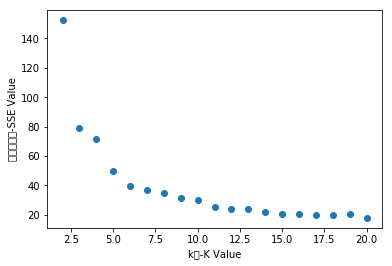

In [40]:
import matplotlib.pyplot as plt
cluster_number = range(2,10)
plt.scatter(squared_errors.keys(),squared_errors.values())
plt.xlabel(u'k值-K Value')
plt.ylabel(u'误差平方和-SSE Value')
plt.savefig('K-Value.jpg')
#plt.show()

In [44]:
# 通过图形，查看k=4时较为合适
kmeans = KMeans(featuresCol='features',k=5,)
model = kmeans.fit(data)

In [45]:
predictions=model.transform(data)

In [46]:
predictions.groupBy('species','prediction').count().show()

+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
|    setosa|         2|   23|
|    setosa|         4|   27|
| virginica|         0|   17|
| virginica|         1|   32|
|versicolor|         0|   23|
| virginica|         3|    1|
|versicolor|         3|   27|
+----------+----------+-----+



In [47]:
pandas_df = predictions.toPandas()

In [48]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

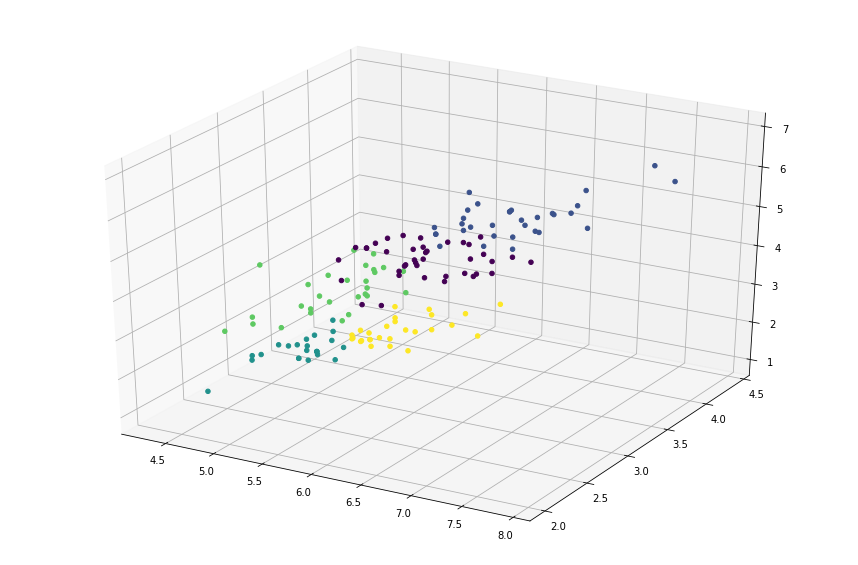

In [49]:
cluster_vis = plt.figure(figsize=(15,10)).gca(projection='3d')
cluster_vis.scatter(pandas_df.sepal_length, pandas_df.sepal_width, pandas_df.petal_length, c=pandas_df.prediction,depthshade=False)
plt.show()